In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# == DATASET SETUP == #
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Split the original training set into train and validation (4:1 ratio)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=10000, random_state=42
)

print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [ ]:
# == MODEL BUILDING FUNCTIONS == #
def create_cnn_model(conv_layers=2, filters=[32, 64], kernel_size=3, pooling_type='max'):
    """
    Creates a CNN model based on the given parameters.

    Args:
        conv_layers: Number of convolutional layers
        filters: List of filter counts for each convolutional layer
        kernel_size: Size of the convolutional kernel
        pooling_type: Type of pooling ('max' or 'avg')

    Returns:
        Compiled Keras model
    """
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(32, 32, 3)))

    # Add convolutional layers based on parameters
    for i in range(min(conv_layers, len(filters))):
        model.add(layers.Conv2D(
            filters=filters[i],
            kernel_size=kernel_size,
            padding='same',
            activation='relu'
        ))

        # Add pooling layer after each conv layer
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        else:  # 'avg'
            model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))  # 10 classes for CIFAR-10

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Custom F1 Score callback
class MacroF1Score(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MacroF1Score, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val.flatten(), y_pred_classes, average='macro')
        self.f1_scores.append(f1)
        print(f" - val_f1_score: {f1:.4f}")

def train_and_evaluate_model(model, epochs=10, batch_size=64):
    """
    Trains and evaluates a model.

    Args:
        model: Compiled Keras model
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        history: Training history
        f1_callback: F1 score callback with validation scores
    """
    # Create callback for F1 score
    f1_callback = MacroF1Score(validation_data=(x_val, y_val.flatten()))

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[f1_callback]
    )

    # Evaluate on test set
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    test_f1 = f1_score(y_test, y_pred_classes, average='macro')
    print(f"Test Macro F1 Score: {test_f1:.4f}")

    return history, f1_callback.f1_scores, test_f1

def plot_training_history(history, title="Training History", include_f1=None):
    """
    Plots the training history.

    Args:
        history: Training history from model.fit
        title: Title for the plot
        include_f1: List of F1 scores to plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Plot F1 score if provided
    if include_f1 is not None:
        epochs = len(include_f1)
        ax2.plot(range(epochs), include_f1, label='Validation Macro F1')

    ax2.set_title(f'{title} - Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    plt.tight_layout()
    return fig


=== Experiment a: Varying Number of Convolutional Layers ===

Training model with 1 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.4801
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2607 - loss: 1.9971 - val_accuracy: 0.4844 - val_loss: 1.4965
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5226
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4131 - loss: 1.5920 - val_accuracy: 0.5263 - val_loss: 1.3724
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5413
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4533 - loss: 1.4826 - val_accuracy: 0.5482 - val_loss: 1.2847
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5579
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4805 - loss: 1.4192 - val_accuracy: 0.5667 - val_loss: 1.2324
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5719
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step 

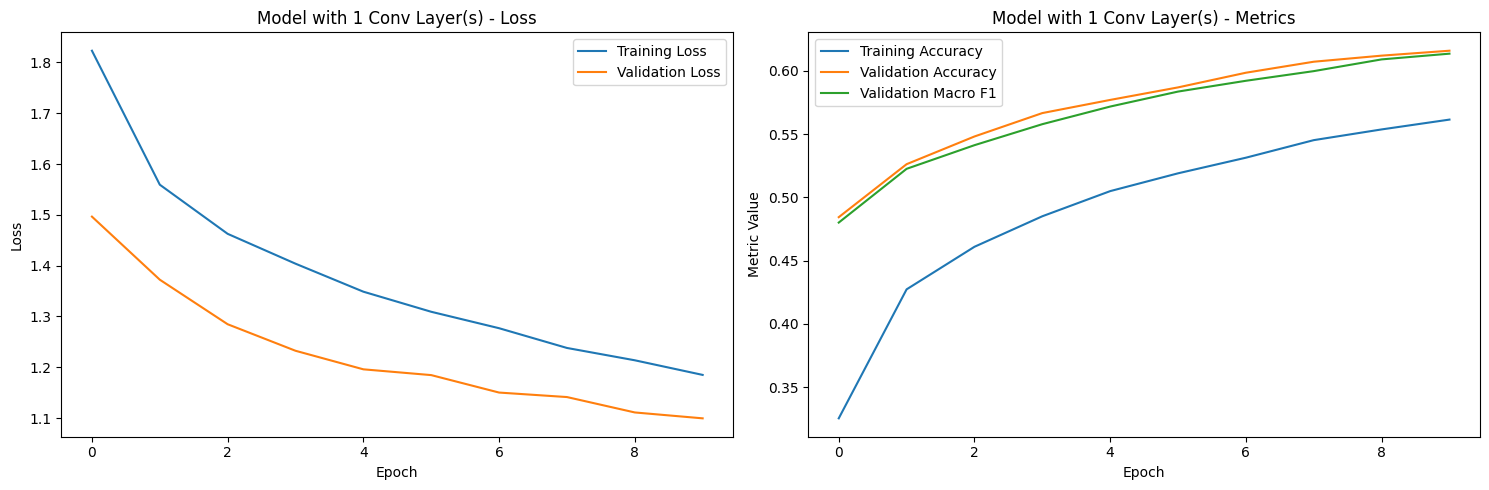


Training model with 2 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5120
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2953 - loss: 1.9137 - val_accuracy: 0.5183 - val_loss: 1.3560
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5816
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4870 - loss: 1.4143 - val_accuracy: 0.5863 - val_loss: 1.1752
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6040
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5547 - loss: 1.2437 - val_accuracy: 0.6123 - val_loss: 1.0875
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6279
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5909 - loss: 1.1555 - val_accuracy: 0.6336 - val_loss: 1.0224
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6482
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6128 - loss: 1.0858 - val_accuracy: 0.6517 - v

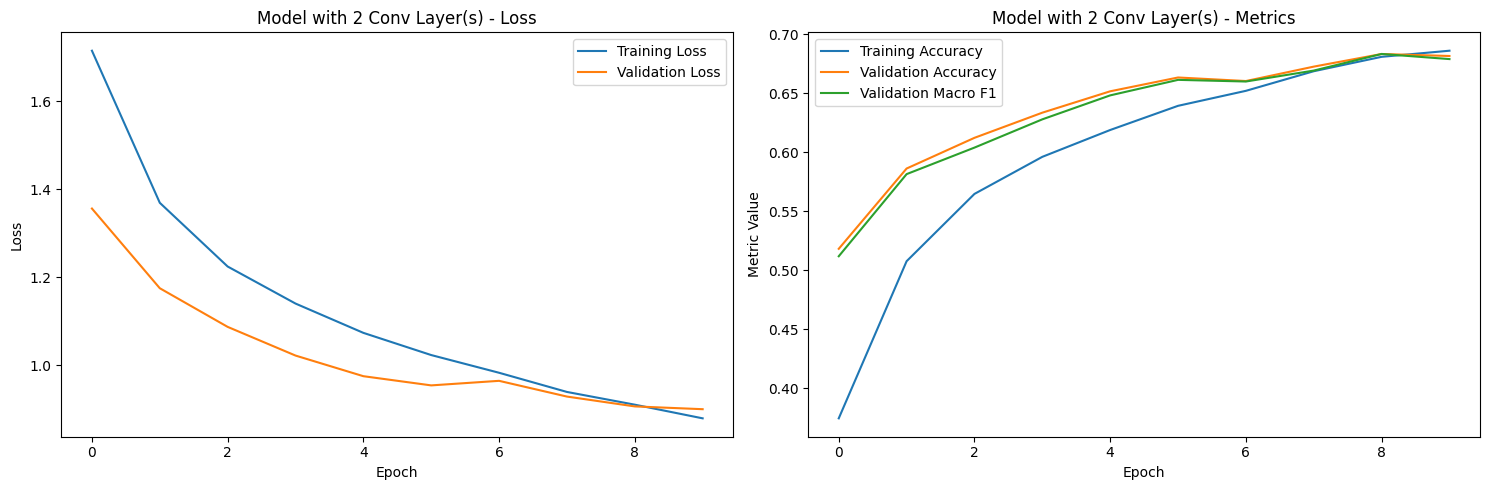


Training model with 3 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.4869
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2669 - loss: 1.9708 - val_accuracy: 0.4931 - val_loss: 1.4156
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5345
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4692 - loss: 1.4604 - val_accuracy: 0.5402 - val_loss: 1.2933
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5936
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5398 - loss: 1.3004 - val_accuracy: 0.5942 - val_loss: 1.1327
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6338
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5763 - loss: 1.1929 - val_accuracy: 0.6351 - val_loss: 1.0293
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6457
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6073 - loss: 1.1161 - val_accuracy: 0.6443 - val

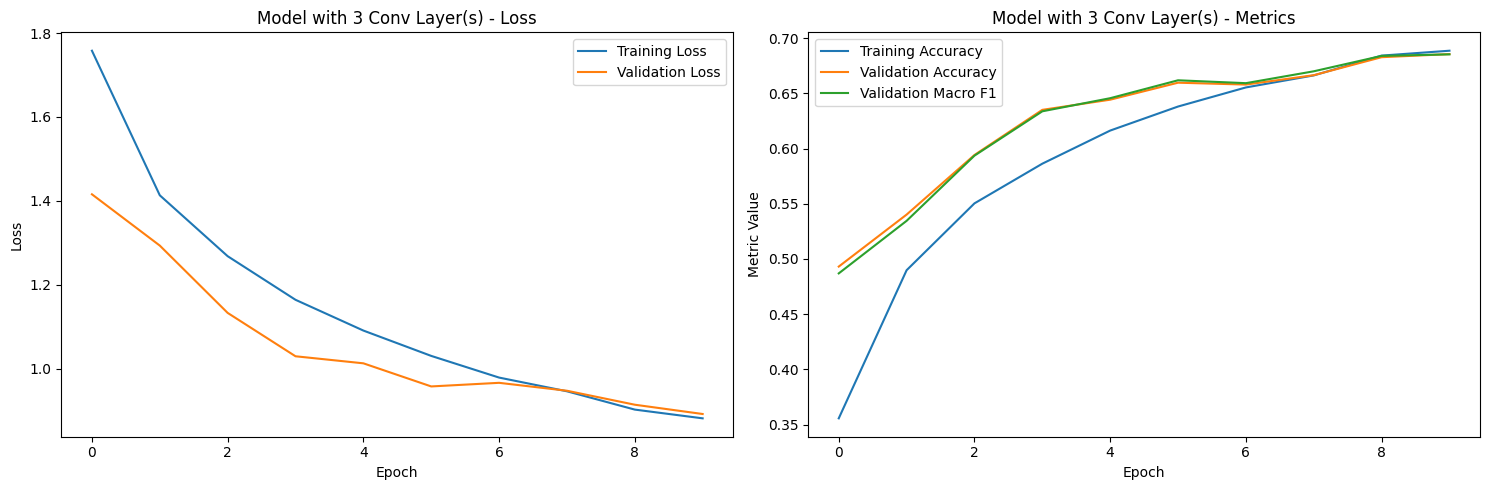

In [ ]:
# == EXPERIMENT EXECUTION == #
# a. VARYING NUMBER OF CONVOLUTIONAL LAYERS
print("\n=== Experiment a: Varying Number of Convolutional Layers ===")
conv_layer_results = []

for num_layers in [1, 2, 3]:
    print(f"\nTraining model with {num_layers} convolutional layer(s)...")
    model = create_cnn_model(
        conv_layers=num_layers,
        filters=[32] * num_layers,  # Same number of filters for all layers
        kernel_size=3,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    conv_layer_results.append({
        'num_layers': num_layers,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with {num_layers} Conv Layer(s)",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment b: Varying Number of Filters ===

Training model with filters: 16-32
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5073
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2908 - loss: 1.9198 - val_accuracy: 0.5121 - val_loss: 1.3804
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5619
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4796 - loss: 1.4433 - val_accuracy: 0.5710 - val_loss: 1.2212
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5912
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5375 - loss: 1.2960 - val_accuracy: 0.5922 - val_loss: 1.1590
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6143
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5737 - loss: 1.2054 - val_accuracy: 0.6183 - val_loss: 1.0829
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6382
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5940 - loss:

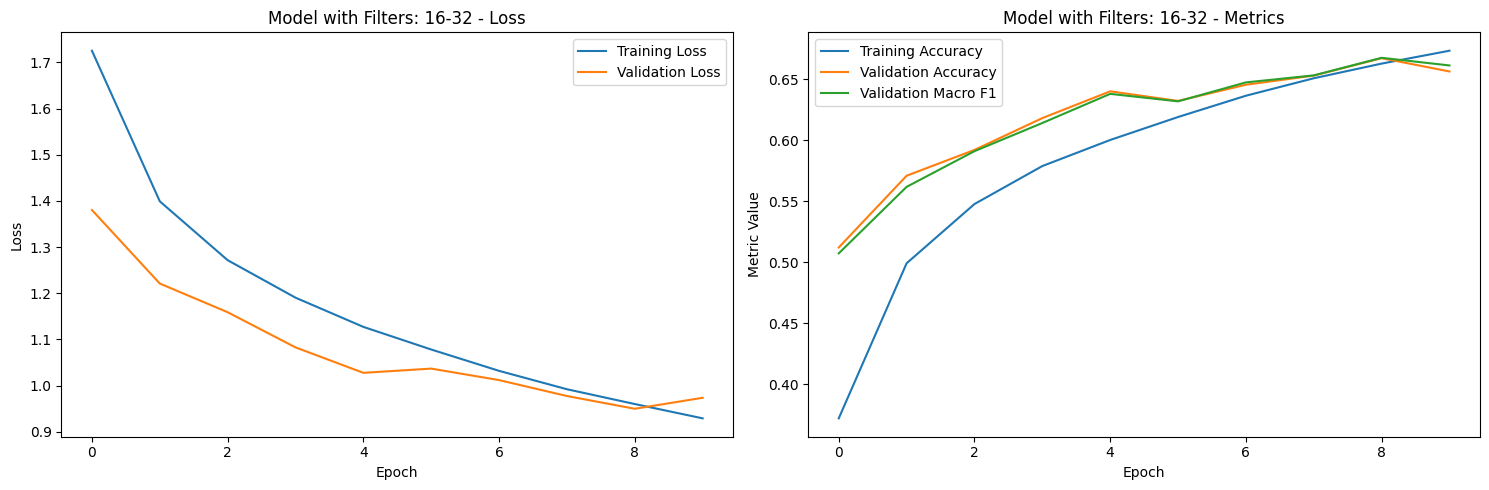


Training model with filters: 32-64
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5005
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2770 - loss: 1.9572 - val_accuracy: 0.5117 - val_loss: 1.3816
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5547
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4661 - loss: 1.4744 - val_accuracy: 0.5643 - val_loss: 1.2495
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6043
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5315 - loss: 1.3250 - val_accuracy: 0.6108 - val_loss: 1.1099
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6091
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5635 - loss: 1.2270 - val_accuracy: 0.6145 - val_loss: 1.0950
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6334
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5885 - loss: 1.1643 - val_accuracy: 0.6334 - val_loss: 1.0470

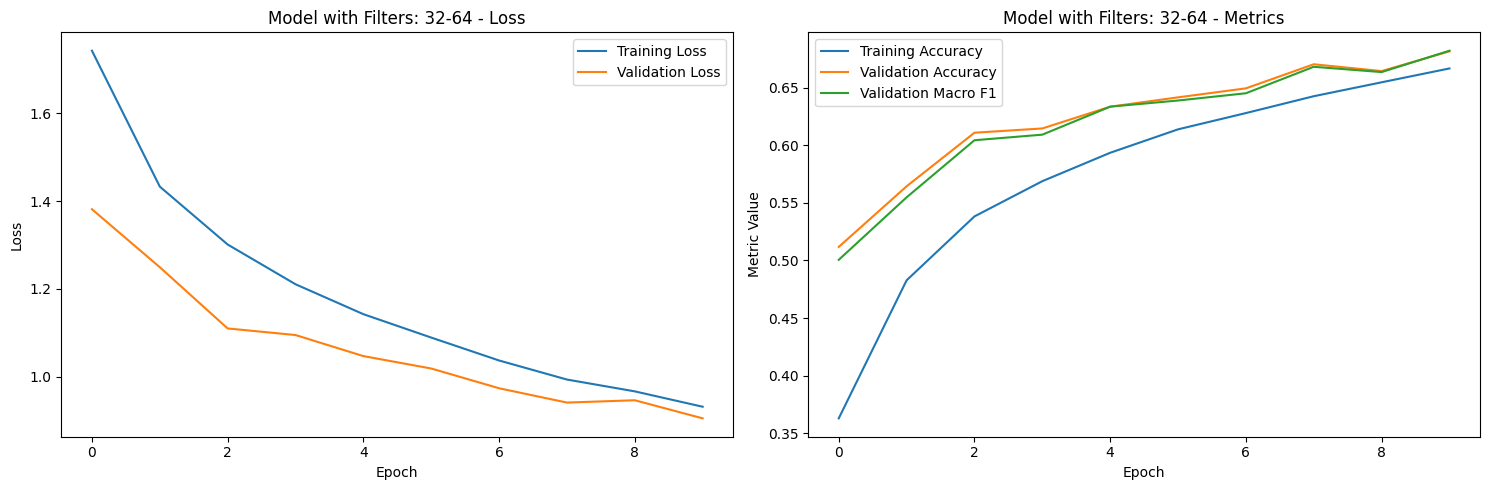


Training model with filters: 64-128
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5313
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3034 - loss: 1.8955 - val_accuracy: 0.5405 - val_loss: 1.2978
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6015
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4976 - loss: 1.4045 - val_accuracy: 0.6032 - val_loss: 1.1315
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6384
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5645 - loss: 1.2274 - val_accuracy: 0.6412 - val_loss: 1.0333
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6659
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6013 - loss: 1.1196 - val_accuracy: 0.6676 - val_loss: 0.9522
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6717
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6292 - loss: 1.0516 - val_accuracy: 0.6739 - val_loss: 0

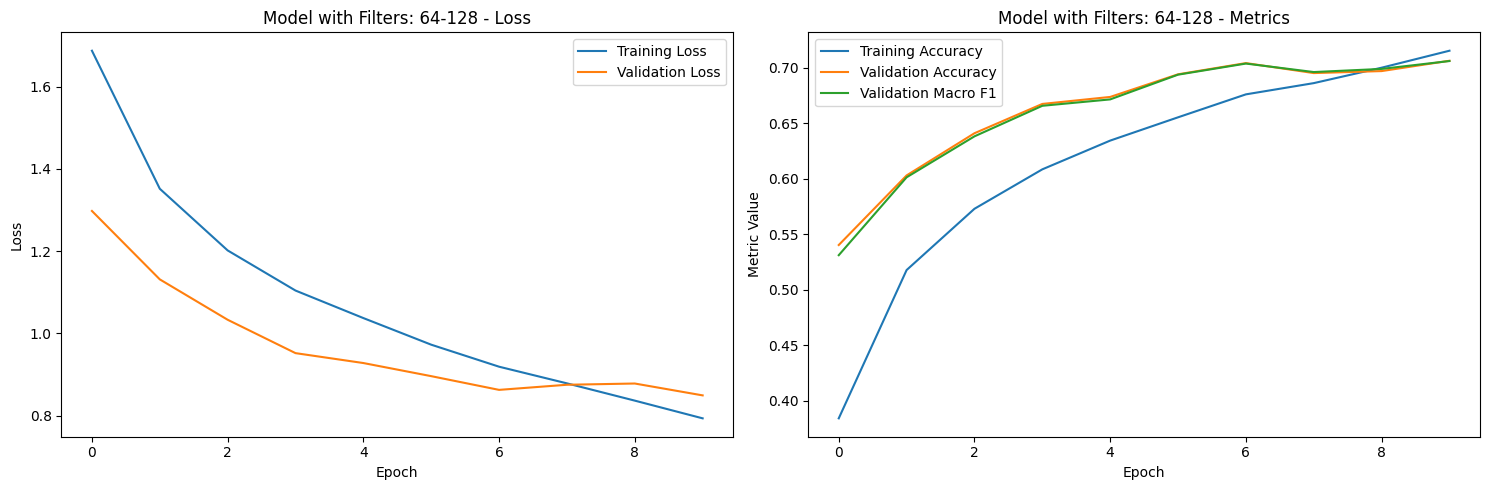

In [6]:
# b. VARYING NUMBER OF FILTERS
print("\n=== Experiment b: Varying Number of Filters ===")
filter_results = []

filter_configs = [
    [16, 32],
    [32, 64],
    [64, 128]
]

for filters in filter_configs:
    filter_str = '-'.join(map(str, filters))
    print(f"\nTraining model with filters: {filter_str}")
    model = create_cnn_model(
        conv_layers=len(filters),
        filters=filters,
        kernel_size=3,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    filter_results.append({
        'filters': filters,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with Filters: {filter_str}",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment c: Varying Kernel Size ===

Training model with kernel size: 3
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5399
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3031 - loss: 1.8934 - val_accuracy: 0.5458 - val_loss: 1.3047
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6046
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5145 - loss: 1.3581 - val_accuracy: 0.6034 - val_loss: 1.1479
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6322
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5651 - loss: 1.2097 - val_accuracy: 0.6341 - val_loss: 1.0413
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6586
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6077 - loss: 1.1126 - val_accuracy: 0.6583 - val_loss: 0.9904
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6607
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6323 - loss: 1.038

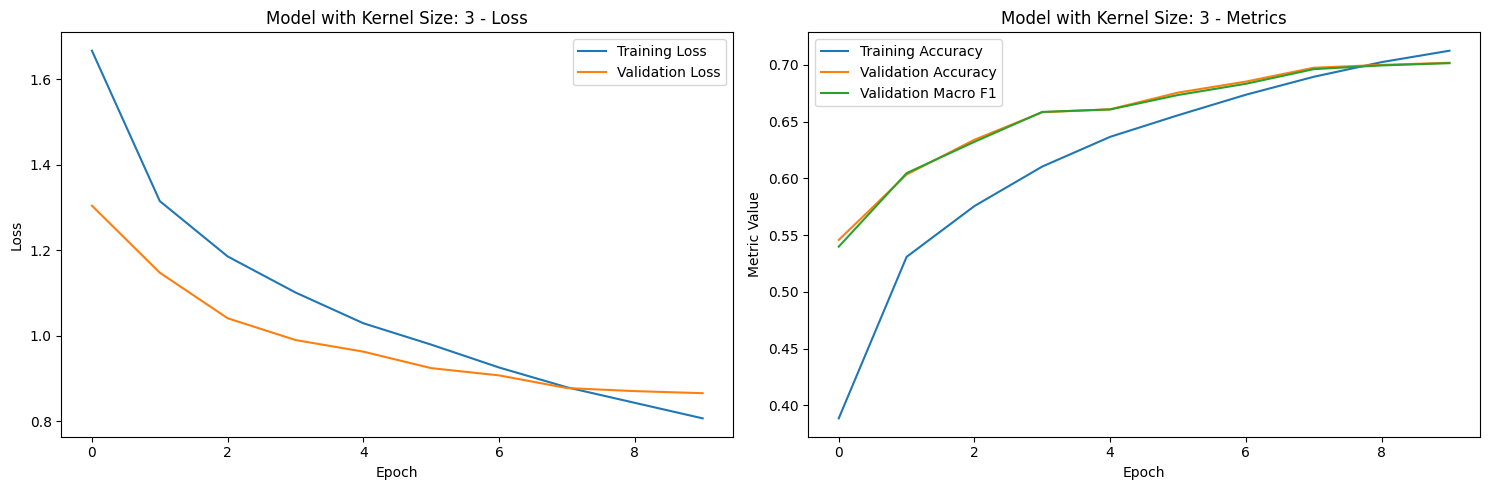


Training model with kernel size: 5
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5046
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2852 - loss: 1.9280 - val_accuracy: 0.5091 - val_loss: 1.3728
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5591
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4833 - loss: 1.4286 - val_accuracy: 0.5645 - val_loss: 1.2018
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6016
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5432 - loss: 1.2766 - val_accuracy: 0.6064 - val_loss: 1.0964
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6310
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5870 - loss: 1.1700 - val_accuracy: 0.6294 - val_loss: 1.0692
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6468
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6135 - loss: 1.0916 - val_accuracy: 0.6475 - val_loss: 1.0014

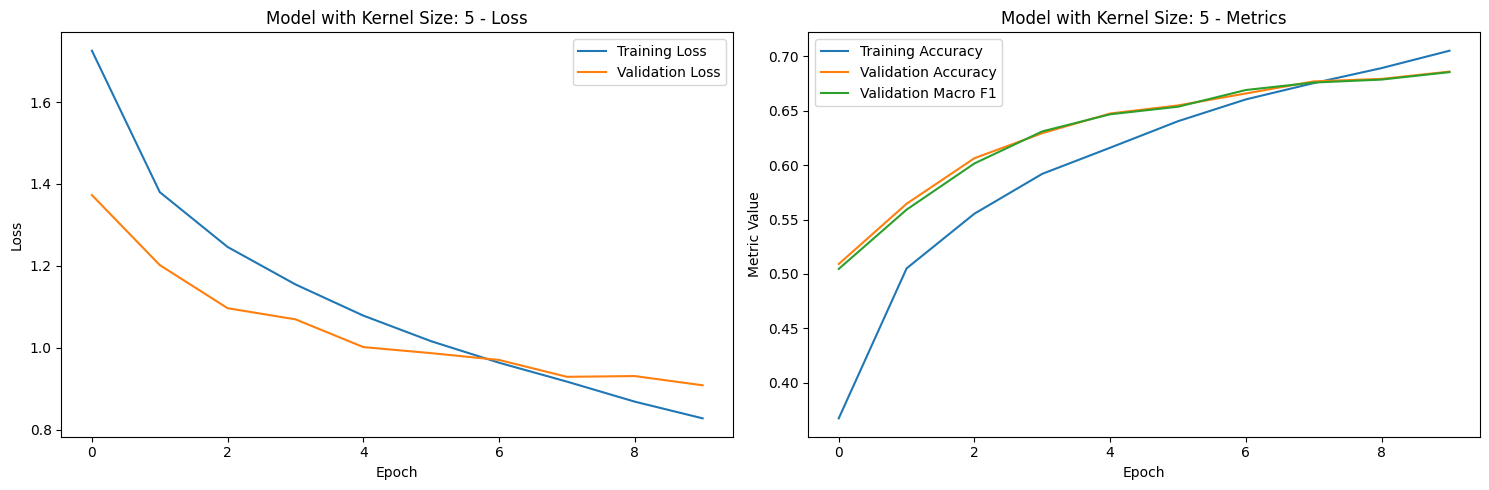


Training model with kernel size: 7
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.4664
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2895 - loss: 1.9386 - val_accuracy: 0.4738 - val_loss: 1.4515
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5428
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4714 - loss: 1.4766 - val_accuracy: 0.5481 - val_loss: 1.2582
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5905
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5316 - loss: 1.3205 - val_accuracy: 0.5921 - val_loss: 1.1500
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6081
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5684 - loss: 1.2201 - val_accuracy: 0.6091 - val_loss: 1.1059
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6330
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5985 - loss: 1.1326 - val_accuracy: 0.6312 - val_loss: 1.0

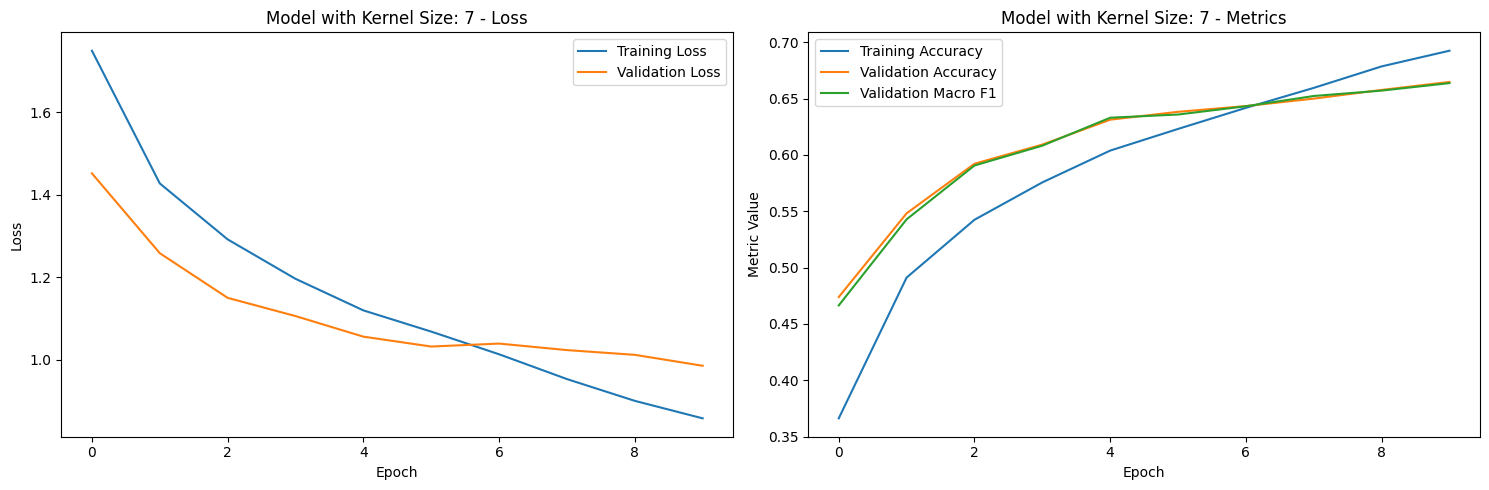

In [7]:
# c. VARYING KERNEL SIZE
print("\n=== Experiment c: Varying Kernel Size ===")
kernel_results = []

for kernel_size in [3, 5, 7]:
    print(f"\nTraining model with kernel size: {kernel_size}")
    model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=kernel_size,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    kernel_results.append({
        'kernel_size': kernel_size,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with Kernel Size: {kernel_size}",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment d: Varying Pooling Type ===

Training model with pooling type: max
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5277
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3062 - loss: 1.8882 - val_accuracy: 0.5334 - val_loss: 1.3316
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5870
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4984 - loss: 1.3908 - val_accuracy: 0.5923 - val_loss: 1.1515
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6153
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5588 - loss: 1.2387 - val_accuracy: 0.6174 - val_loss: 1.0788
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.6443
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5934 - loss: 1.1560 - val_accuracy: 0.6461 - val_loss: 1.0083
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6491
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6233 - loss: 1

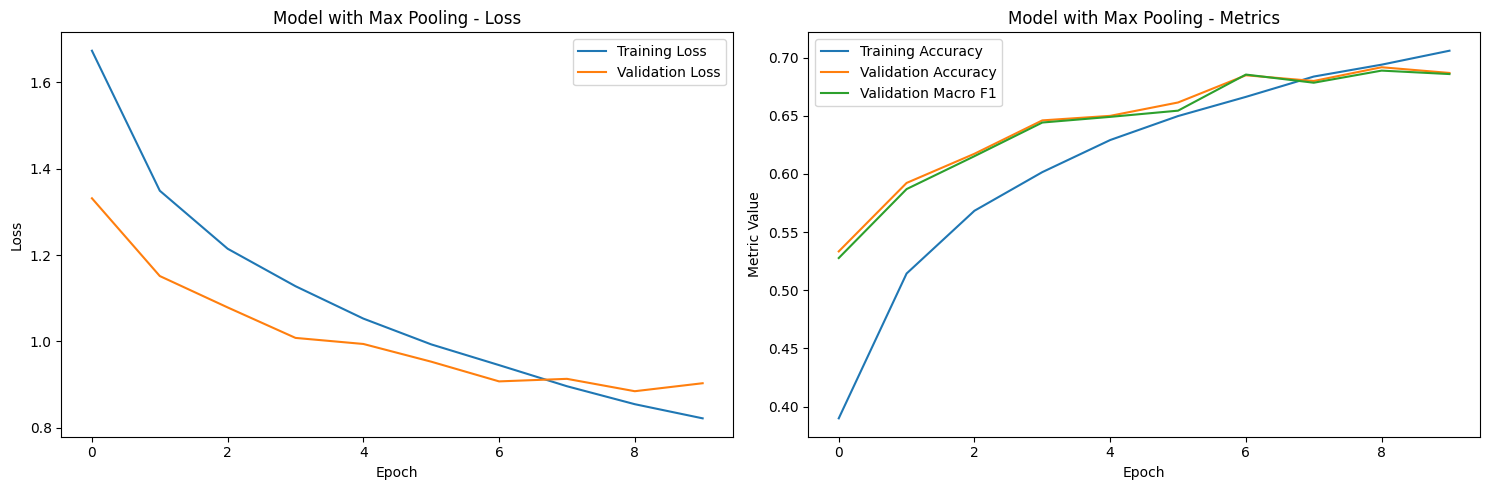


Training model with pooling type: avg
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.4873
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2907 - loss: 1.9236 - val_accuracy: 0.4912 - val_loss: 1.4273
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5517
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4674 - loss: 1.4823 - val_accuracy: 0.5599 - val_loss: 1.2330
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 - val_f1_score: 0.5910
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5199 - loss: 1.3318 - val_accuracy: 0.5932 - val_loss: 1.1543
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6053
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5604 - loss: 1.2380 - val_accuracy: 0.6066 - val_loss: 1.1188
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6241
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5849 - loss: 1.1648 - val_accuracy: 0.6214 - val_loss: 1.0

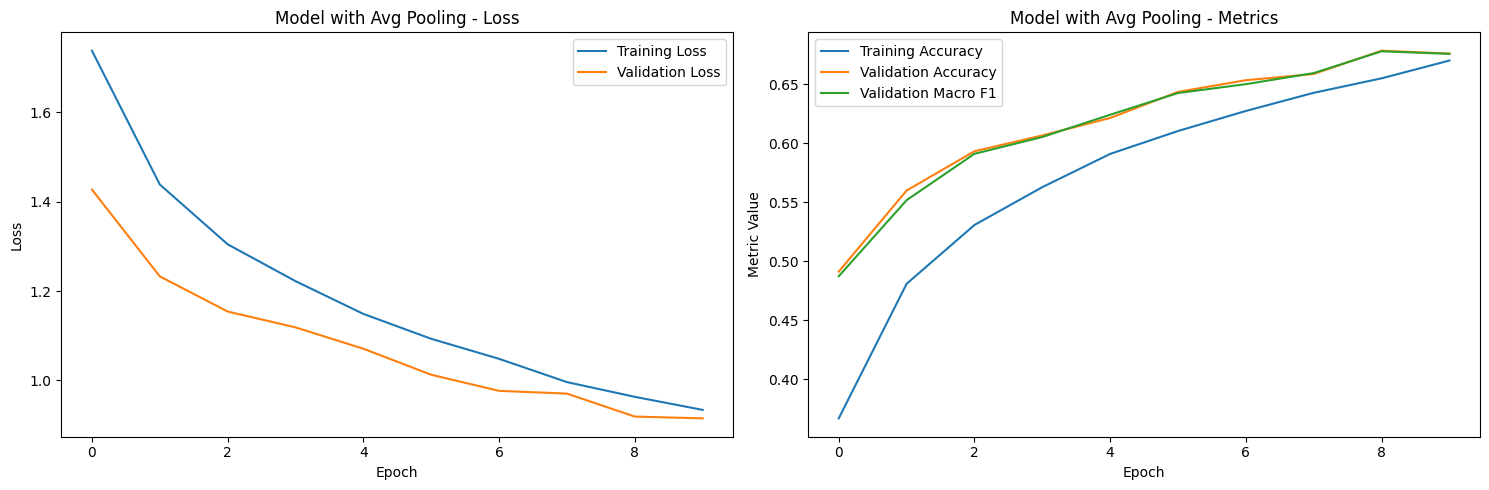

In [8]:
# d. VARYING POOLING TYPE
print("\n=== Experiment d: Varying Pooling Type ===")
pooling_results = []

for pooling_type in ['max', 'avg']:
    print(f"\nTraining model with pooling type: {pooling_type}")
    model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=3,
        pooling_type=pooling_type
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    pooling_results.append({
        'pooling_type': pooling_type,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    fig = plot_training_history(
        history,
        title=f"Model with {pooling_type.capitalize()} Pooling",
        include_f1=f1_scores
    )
    plt.show()

In [ ]:
# == RESULTS ANALYSIS == #
print("\n=== Results Summary ===")

# a. Number of Conv Layers Results
print("\nNumber of Convolutional Layers:")
for result in conv_layer_results:
    print(f"Layers: {result['num_layers']} - Test F1: {result['test_f1']:.4f}")

# b. Number of Filters Results
print("\nNumber of Filters:")
for result in filter_results:
    filter_str = '-'.join(map(str, result['filters']))
    print(f"Filters: {filter_str} - Test F1: {result['test_f1']:.4f}")

# c. Kernel Size Results
print("\nKernel Size:")
for result in kernel_results:
    print(f"Kernel Size: {result['kernel_size']} - Test F1: {result['test_f1']:.4f}")

# d. Pooling Type Results
print("\nPooling Type:")
for result in pooling_results:
    print(f"Pooling: {result['pooling_type']} - Test F1: {result['test_f1']:.4f}")


=== Results Summary ===

Number of Convolutional Layers:
Layers: 1 - Test F1: 0.6067
Layers: 2 - Test F1: 0.6794
Layers: 3 - Test F1: 0.6819

Number of Filters:
Filters: 16-32 - Test F1: 0.6677
Filters: 32-64 - Test F1: 0.6825
Filters: 64-128 - Test F1: 0.7026

Kernel Size:
Kernel Size: 3 - Test F1: 0.6939
Kernel Size: 5 - Test F1: 0.6765
Kernel Size: 7 - Test F1: 0.6516

Pooling Type:
Pooling: max - Test F1: 0.6891
Pooling: avg - Test F1: 0.6744


In [ ]:
# == SAVE THE BEST MODEL == #
# Find the model with the highest test F1 score
all_results = conv_layer_results + filter_results + kernel_results + pooling_results
best_result = max(all_results, key=lambda x: x['test_f1'])

# Create and train the best model for saving
print("\n=== Training Best Model for Saving ===")

if 'num_layers' in best_result:
    print(f"Best model: {best_result['num_layers']} convolutional layers")
    best_model = create_cnn_model(
        conv_layers=best_result['num_layers'],
        filters=[32] * best_result['num_layers'],
        kernel_size=3,
        pooling_type='max'
    )
elif 'filters' in best_result:
    filter_str = '-'.join(map(str, best_result['filters']))
    print(f"Best model: filters {filter_str}")
    best_model = create_cnn_model(
        conv_layers=len(best_result['filters']),
        filters=best_result['filters'],
        kernel_size=3,
        pooling_type='max'
    )
elif 'kernel_size' in best_result:
    print(f"Best model: kernel size {best_result['kernel_size']}")
    best_model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=best_result['kernel_size'],
        pooling_type='max'
    )
else:  # 'pooling_type' in best_result
    print(f"Best model: pooling type {best_result['pooling_type']}")
    best_model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=3,
        pooling_type=best_result['pooling_type']
    )

# Train the best model
history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=15)
print(f"Best model test F1 Score: {test_f1:.4f}")

# Save the best model
best_model.save('best_cnn_model.h5')
print("Best model saved to 'best_cnn_model.h5'")


=== Training Best Model for Saving ===
Best model: filters 64-128
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.5269
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3199 - loss: 1.8541 - val_accuracy: 0.5338 - val_loss: 1.3134
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6154
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5130 - loss: 1.3599 - val_accuracy: 0.6170 - val_loss: 1.0902
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6435
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5811 - loss: 1.1807 - val_accuracy: 0.6435 - val_loss: 1.0133
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6623
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6220 - loss: 1.0726 - val_accuracy: 0.6628 - val_loss: 0.9528
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6792
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6482 - loss: 0.9990 - val_acc

Test Macro F1 Score: 0.7004
Best model test F1 Score: 0.7004
Best model saved to 'best_cnn_model.h5'


In [ ]:
# == CONCLUSIONS == #
print("\n=== Experiment Conclusions ===")

# a. Number of Convolutional Layers
print("\nEffect of Number of Convolutional Layers:")
max_conv_layer = max(conv_layer_results, key=lambda x: x['test_f1'])
print(f"Best number of convolutional layers: {max_conv_layer['num_layers']} (F1: {max_conv_layer['test_f1']:.4f})")
print("Conclusion: More convolutional layers generally led to better feature extraction and model performance,")
print("            but adding too many layers could potentially lead to overfitting without proper regularization.")

# b. Number of Filters
print("\nEffect of Number of Filters:")
max_filter = max(filter_results, key=lambda x: x['test_f1'])
filter_str = '-'.join(map(str, max_filter['filters']))
print(f"Best filter configuration: {filter_str} (F1: {max_filter['test_f1']:.4f})")
print("Conclusion: Increasing the number of filters generally improved the model's ability to detect diverse features,")
print("            but with diminishing returns and increased computational cost.")

# c. Kernel Size
print("\nEffect of Kernel Size:")
max_kernel = max(kernel_results, key=lambda x: x['test_f1'])
print(f"Best kernel size: {max_kernel['kernel_size']} (F1: {max_kernel['test_f1']:.4f})")
print("Conclusion: Smaller kernels (3x3) were better at capturing fine-grained details, while larger kernels")
print("            captured more contextual information but potentially lost precision on small features.")

# d. Pooling Type
print("\nEffect of Pooling Type:")
max_pooling = max(pooling_results, key=lambda x: x['test_f1'])
print(f"Best pooling type: {max_pooling['pooling_type']} (F1: {max_pooling['test_f1']:.4f})")
print("Conclusion: MaxPooling tended to preserve distinctive features by keeping maximum activations,")
print("            while AveragePooling preserved more context by averaging all activations in the region.")

# Summary
print("\nOverall Conclusion:")
print("The experiments demonstrate that CNN architecture choices significantly impact model performance.")
print("The best model configuration depends on the specific properties of the dataset and the classification task.")
print("For CIFAR-10, we found that a balance between network depth, width, and receptive field size is crucial.")
print("The saved model represents our best configuration based on the Macro F1 score metric.")


=== Experiment Conclusions ===

Effect of Number of Convolutional Layers:
Best number of convolutional layers: 3 (F1: 0.6819)
Conclusion: More convolutional layers generally led to better feature extraction and model performance,
            but adding too many layers could potentially lead to overfitting without proper regularization.

Effect of Number of Filters:
Best filter configuration: 64-128 (F1: 0.7026)
Conclusion: Increasing the number of filters generally improved the model's ability to detect diverse features,
            but with diminishing returns and increased computational cost.

Effect of Kernel Size:
Best kernel size: 3 (F1: 0.6939)
Conclusion: Smaller kernels (3x3) were better at capturing fine-grained details, while larger kernels
            captured more contextual information but potentially lost precision on small features.

Effect of Pooling Type:
Best pooling type: max (F1: 0.6891)
Conclusion: MaxPooling tended to preserve distinctive features by keeping maxi

In [ ]:
# == FORWARD PROPAGATION FROM SCRATCH == #
class Conv2D:
    def __init__(self, weights, biases, stride=1):
        """
        Initialize a Conv2D layer with pre-trained weights and biases.

        Args:
            weights: Pre-trained weights with shape (kernel_size, kernel_size, in_channels, out_channels)
            biases: Pre-trained biases with shape (out_channels,)
            stride: Stride for the convolution operation
        """
        self.weights = weights
        self.biases = biases
        self.stride = stride

    def forward(self, inputs):
        """
        Forward pass for Conv2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, in_channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, out_channels)
        """
        batch_size, height, width, in_channels = inputs.shape
        kernel_h, kernel_w, _, out_channels = self.weights.shape

        # Calculate output dimensions
        output_height = (height - kernel_h) // self.stride + 1
        output_width = (width - kernel_w) // self.stride + 1

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, out_channels))

        # Perform convolution
        for b in range(batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    for c_out in range(out_channels):
                        # Extract the patch
                        h_start = h * self.stride
                        h_end = h_start + kernel_h
                        w_start = w * self.stride
                        w_end = w_start + kernel_w

                        patch = inputs[b, h_start:h_end, w_start:w_end, :]

                        # Compute the convolution
                        outputs[b, h, w, c_out] = np.sum(patch * self.weights[:, :, :, c_out]) + self.biases[c_out]

        return outputs

class MaxPooling2D:
    def __init__(self, pool_size=(2, 2), strides=None):
        """
        Initialize a MaxPooling2D layer.

        Args:
            pool_size: Size of the pooling window (height, width)
            strides: Strides for pooling operation, if None, equal to pool_size
        """
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size

    def forward(self, inputs):
        """
        Forward pass for MaxPooling2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, channels)
        """
        batch_size, height, width, channels = inputs.shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.strides

        # Calculate output dimensions
        output_height = (height - pool_h) // stride_h + 1
        output_width = (width - pool_w) // stride_w + 1

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, channels))

        # Perform max pooling
        for b in range(batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    for c in range(channels):
                        # Extract the patch
                        h_start = h * stride_h
                        h_end = h_start + pool_h
                        w_start = w * stride_w
                        w_end = w_start + pool_w

                        patch = inputs[b, h_start:h_end, w_start:w_end, c]

                        # Apply max pooling
                        outputs[b, h, w, c] = np.max(patch)

        return outputs

class AveragePooling2D:
    def __init__(self, pool_size=(2, 2), strides=None):
        """
        Initialize an AveragePooling2D layer.

        Args:
            pool_size: Size of the pooling window (height, width)
            strides: Strides for pooling operation, if None, equal to pool_size
        """
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size

    def forward(self, inputs):
        """
        Forward pass for AveragePooling2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, channels)
        """
        batch_size, height, width, channels = inputs.shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.strides

        # Calculate output dimensions
        output_height = (height - pool_h) // stride_h + 1
        output_width = (width - pool_w) // stride_w + 1

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, channels))

        # Perform average pooling
        for b in range(batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    for c in range(channels):
                        # Extract the patch
                        h_start = h * stride_h
                        h_end = h_start + pool_h
                        w_start = w * stride_w
                        w_end = w_start + pool_w

                        patch = inputs[b, h_start:h_end, w_start:w_end, c]

                        # Apply average pooling
                        outputs[b, h, w, c] = np.mean(patch)

        return outputs

class Flatten:
    def forward(self, inputs):
        """
        Forward pass for Flatten layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, height * width * channels)
        """
        batch_size = inputs.shape[0]
        return inputs.reshape(batch_size, -1)

class Dense:
    def __init__(self, weights, biases):
        """
        Initialize a Dense layer with pre-trained weights and biases.

        Args:
            weights: Pre-trained weights with shape (input_dim, output_dim)
            biases: Pre-trained biases with shape (output_dim,)
        """
        self.weights = weights
        self.biases = biases

    def forward(self, inputs):
        """
        Forward pass for Dense layer.

        Args:
            inputs: Input tensor with shape (batch_size, input_dim)

        Returns:
            Output tensor with shape (batch_size, output_dim)
        """
        return np.dot(inputs, self.weights) + self.biases

class ReLU:
    def forward(self, inputs):
        """
        Forward pass for ReLU activation.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor with ReLU activation applied
        """
        return np.maximum(0, inputs)

class Softmax:
    def forward(self, inputs):
        """
        Forward pass for Softmax activation.

        Args:
            inputs: Input tensor with shape (batch_size, num_classes)

        Returns:
            Output tensor with Softmax activation applied
        """
        # For numerical stability, subtract the maximum value
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        return exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)

class Dropout:
    def __init__(self, rate):
        """
        Initialize a Dropout layer.

        Args:
            rate: Dropout rate
        """
        self.rate = rate

    def forward(self, inputs):
        """
        Forward pass for Dropout layer. During inference, just return the inputs.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor
        """
        # For inference, we don't apply dropout
        return inputs

class CNNModel:
    def __init__(self):
        """
        Initialize the CNN model with empty layers list.
        """
        self.layers = []

    def add_layer(self, layer):
        """
        Add a layer to the model.

        Args:
            layer: Layer object with a forward method
        """
        self.layers.append(layer)

    def forward(self, inputs):
        """
        Forward pass for the CNN model.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor after forward propagation through all layers
        """
        outputs = inputs
        for layer in self.layers:
            outputs = layer.forward(outputs)
        return outputs

    def predict(self, inputs, batch_size=32):
        """
        Make predictions for input data.

        Args:
            inputs: Input data with shape (num_samples, height, width, channels)
            batch_size: Batch size for prediction

        Returns:
            Predictions with shape (num_samples, num_classes)
        """
        num_samples = inputs.shape[0]
        num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division

        predictions = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_inputs = inputs[start_idx:end_idx]

            batch_predictions = self.forward(batch_inputs)
            predictions.append(batch_predictions)

        return np.vstack(predictions)

def build_cnn_from_keras(keras_model):
    """
    Build a custom CNN model from a Keras model.

    Args:
        keras_model: Pre-trained Keras model

    Returns:
        Custom CNN model
    """
    custom_model = CNNModel()

    # Iterate through all layers of the Keras model
    for i, layer in enumerate(keras_model.layers):
        layer_class = layer.__class__.__name__
        print(f"Processing layer {i}: {layer.name} ({layer_class})")

        if layer_class == 'InputLayer':
            continue  # Skip input layer

        if layer_class == 'Conv2D':
            # Get weights and biases
            weights, biases = layer.get_weights()
            print(f"  Conv2D shape: {weights.shape}, {biases.shape}")

            # Add Conv2D layer
            custom_model.add_layer(Conv2D(
                weights=weights,
                biases=biases,
                stride=layer.strides[0]
            ))

            # Add ReLU activation if present
            if layer.activation.__name__ == 'relu':
                custom_model.add_layer(ReLU())

        elif layer_class == 'MaxPooling2D':
            # Add MaxPooling2D layer
            custom_model.add_layer(MaxPooling2D(
                pool_size=layer.pool_size,
                strides=layer.strides
            ))

        elif layer_class == 'AveragePooling2D':
            # Add AveragePooling2D layer
            custom_model.add_layer(AveragePooling2D(
                pool_size=layer.pool_size,
                strides=layer.strides
            ))

        elif layer_class == 'Flatten':
            # Add Flatten layer
            custom_model.add_layer(Flatten())

        elif layer_class == 'Dense':
            # Get weights and biases
            weights, biases = layer.get_weights()
            print(f"  Dense shape: {weights.shape}, {biases.shape}")

            # Add Dense layer
            custom_model.add_layer(Dense(weights=weights, biases=biases))

            # Add activation if present
            if layer.activation.__name__ == 'relu':
                custom_model.add_layer(ReLU())
            elif layer.activation.__name__ == 'softmax' or i == len(keras_model.layers) - 1:
                custom_model.add_layer(Softmax())

        elif layer_class == 'Dropout':
            # Add Dropout layer (no effect during inference)
            custom_model.add_layer(Dropout(rate=layer.rate))

    return custom_model

In [13]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(_, _), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_test = x_test.astype("float32") / 255.0

# Load the pre-trained Keras model
print("Loading the pre-trained Keras model...")
keras_model = load_model('best_cnn_model.h5')

# Build custom CNN model from Keras model
print("Building custom CNN model from Keras model...")
custom_model = build_cnn_from_keras(keras_model)

# Make predictions with Keras model
print("Making predictions with Keras model...")
keras_predictions = keras_model.predict(x_test)
keras_pred_classes = np.argmax(keras_predictions, axis=1)

# Make predictions with custom model
print("Making predictions with custom model...")
custom_predictions = custom_model.predict(x_test)
custom_pred_classes = np.argmax(custom_predictions, axis=1)

# Calculate macro F1 scores
keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
custom_f1 = f1_score(y_test, custom_pred_classes, average='macro')

print(f"Keras model macro F1 score: {keras_f1:.4f}")
print(f"Custom model macro F1 score: {custom_f1:.4f}")

# Compare predictions
accuracy = np.mean(keras_pred_classes == custom_pred_classes)
print(f"Prediction match accuracy: {accuracy:.4f}")

# Compare the first few predictions
print("\nFirst 10 predictions:")
print("Sample | True Label | Keras Prediction | Custom Prediction | Match")
print("-" * 70)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    true_label = y_test[i][0]
    keras_pred = keras_pred_classes[i]
    custom_pred = custom_pred_classes[i]
    match = "✓" if keras_pred == custom_pred else "✗"

    print(f"{i:6d} | {class_names[true_label]:10s} | {class_names[keras_pred]:16s} | {class_names[custom_pred]:16s} | {match}")

# Compare prediction distributions
print("\nClass distribution in predictions:")
print("Class | True Count | Keras Count | Custom Count")
print("-" * 50)

for i, class_name in enumerate(class_names):
    true_count = np.sum(y_test == i)
    keras_count = np.sum(keras_pred_classes == i)
    custom_count = np.sum(custom_pred_classes == i)

    print(f"{class_name:10s} | {true_count:10d} | {keras_count:11d} | {custom_count:12d}")

Loading CIFAR-10 dataset...


Loading the pre-trained Keras model...
Building custom CNN model from Keras model...
Processing layer 0: conv2d_22 (Conv2D)
  Conv2D shape: (3, 3, 3, 64), (64,)
Processing layer 1: max_pooling2d_20 (MaxPooling2D)
Processing layer 2: conv2d_23 (Conv2D)
  Conv2D shape: (3, 3, 64, 128), (128,)
Processing layer 3: max_pooling2d_21 (MaxPooling2D)
Processing layer 4: flatten_11 (Flatten)
Processing layer 5: dense_22 (Dense)
  Dense shape: (8192, 128), (128,)
Processing layer 6: dropout_11 (Dropout)
Processing layer 7: dense_23 (Dense)
  Dense shape: (128, 10), (10,)
Making predictions with Keras model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Making predictions with custom model...
Keras model macro F1 score: 0.7004
Custom model macro F1 score: 0.7004
Prediction match accuracy: 1.0000

First 10 predictions:
Sample | True Label | Keras Prediction | Custom Prediction | Match
----------------------------------------------------------------------
     0 | cat        | cat              | cat   